## Final Project Submission

Please fill out:
* Student name: Dominick D'Andrea 
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


# Initial Thoughts and Questions

## Initial Thoughts
The purpose of this project is to conduct data analysis that explores what type of films are currently doing the best at the box office. Before beginning to look at the data, it is important to establish flexible guidelines to make the process efficient without overanalyzing or going down unnecessary rabit holes. The key modifier here is flexible; while the guidelines will help to make the process efficient and goal-oriented, findings from the data may alter the path taken if the data prompts additional questions. 

The first step will therefore be in identifying the objective, which was stated above, and the quesions needed to be answered to complete the objective.

## Some Questions
These questions will help guide the data analysis process. They are meant to serve as an initial launching point, not a definitive or immutable set of questions.
- What genre/type of movie is currently doing the best, as measured by star ratings?
This is an obvious but important question to answer given the objective.
- What is does the worldwide gross look like for each genre?
This is a good indicator of the success of a genre, and a key component in determing potential ROI.
- What does the production cost look like for each genre?
The second component of calculating ROI, this will also help to determine the feasability to producing a movie is each genre. As a new studio, it would be prudent to keep costs as low as possible.

In [1]:
# import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

%matplotlib inline

/Users/dominickdandrea/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import and view each dataset to collect information

### Observations
1. The IMDB datasets can be connected through a unique identifier, known as the 'tconst.'
2. The primary datasets to work with will be title_basics, title_ratings, and budget:

    - title_basics: This will provide the genres and original dates

    - title_ratings: This will provide the ratings for each movie, and hence each genre

    - budget: Provides the budget and gross for movies

The other datasets may come into play, but there is no apparent need for them at this time. The other datasets don't appear to contain relevant (or they contain duplicate) information to answer our questions. If they are needed, a note will be made explaining why. 

# Import the databases and observe what each containts
Quickly view the datasets (from IMDB and tn.movie) to identify available data and potential keys to join datasets on

##### Note: For exploratory purposes; not all may be used for the analysis

In [2]:
# quickly view the datasets (from IMDB) to identify available data and primary key to join datasets on
name_basics = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
# name_basics.info()

In [3]:
title_akas = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
# title_akas.info()

In [23]:
title_basics = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
title_basics.rename(columns = {'start_year': 'year', 'primary_title': 'movie'}, inplace=True)
title_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   movie            146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   year             146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [5]:
title_crew = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
# title_crew.info()

In [6]:
title_principals = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
# title_principals.info()

In [7]:
title_rating = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
# title_rating.info()

In [8]:
# import budget information, change release_date to datetime, create year column
budget = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
budget['release_date'] = pd.to_datetime(budget['release_date'])
budget['year'] = pd.DatetimeIndex(budget['release_date']).year

# Explore the data and perform merges on relevant databases
The primary purpose is to merge the dataframes and perform some clean-up to get a solid database. 

In [24]:
# merge title_basics and title_ratings 
basics_ratings = title_basics.merge(title_rating, on='tconst', how='outer')

# genres stored as a string; split into list of strings
basics_ratings['genres'] = basics_ratings['genres'].str.split(',')

# drop movies with no genre - they will not be helpful
basics_ratings.dropna(subset=['genres'], inplace = True)

# merge budget and basics_ratings - merge on movie and year to prevent errors when 
# the same title appears for different movies
movie_financials = budget.merge(basics_ratings, how='inner', left_on=['movie', 'year'], right_on=['movie', 'year'])

# drop some of the irrelevant columns to keep the database clean
irrelevant_columns = ['id', 'release_date', 'tconst', 'original_title']
movie_financials.drop(columns=irrelevant_columns, inplace=True)

# sanity check to make sure the merge worked
movie_financials.loc[movie_financials['movie'].str.contains('Pirates of the Caribbean')]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 140736 entries, 0 to 146143
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           140736 non-null  object 
 1   movie            140736 non-null  object 
 2   original_title   140734 non-null  object 
 3   year             140736 non-null  int64  
 4   runtime_minutes  112233 non-null  float64
 5   genres           140736 non-null  object 
 6   averagerating    73052 non-null   float64
 7   numvotes         73052 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 9.7+ MB


In [10]:
'''
Each movie can have multiple genres; this function will extrapolate each genre a movie falls in
and create a dictionary to store all the genres along with the counts. The dictionary is then converted
back into a pandas dataframe.

Parameter: 
dataset - the dataset that includes the genres of each movie

Variables:
genres_dict - a dictionary to keep track of the count of each genre
df - genres_dict converted into a pandas dataframe
'''

def genre_count(dataset):
    genres_dict = {}
    for index, value in dataset.iterrows():
        for genre in value['genres']:
            if genre in genres_dict:
                genres_dict[genre] += 1
            else:
                genres_dict[genre] = 0
    df = pd.DataFrame.from_dict(genres_dict, orient='index')
    return df

In [11]:
# store the output of genre_count in a variable
genre_df = genre_count(basics_ratings)

# reset dataframe index
genre_df.reset_index(inplace=True)

# rename dataframe columns
genre_df.rename({'index': 'Genre', 0: 'Count'}, inplace = True, axis=1)

# sort dataframe by count
genre_df.sort_values(by=['Count'], ascending=False, inplace=True)

## Q1: How many movies exist in each genre?

In [12]:
# drop genres that do not have many movies
to_drop=['War', 'Western', 'Reality-TV', 'Talk-Show', 'Adult', 'Game-Show', 'Short']
genre_df.set_index('Genre', inplace=True)
genre_df.drop(labels=to_drop, axis=0, inplace=True)
genre_df.reset_index(inplace=True)

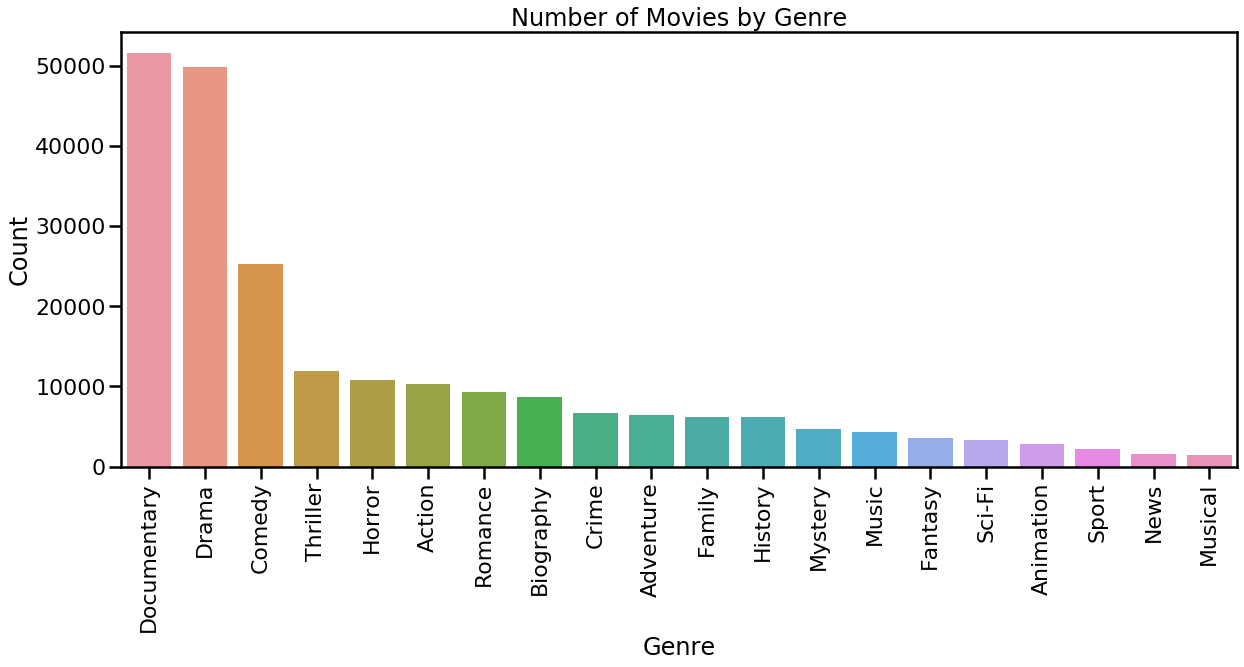

In [13]:
sns.set_context("poster")
plt.figure(figsize=(20,8))
sns.barplot(x='Genre', y='Count', data=genre_df)
plt.title('Number of Movies by Genre')
plt.xticks(rotation=90);

# Explore genre financials
Now that we know how many movies exist in each category and the rating for each genre, let's explore the financials of each genre to get a better idea of what genre will be most lucrative.

In [14]:
'''
This function is used to create a dataframe containing the relevant information for each genre.
Note: Worldwide gross was used as a measure for revenue; depending on what we are interested in, we could
      substitute domestic gross, intead.

Parameter:
dataframe - dataframe to parse through

Variables:
genre_list - a list of lists containing the genre and relevant information for each movie
genre_info - a list containing an individual genre and the relevant information for that movie of that
             particular genre
df - a dataframe from the genre_list
'''

def get_info(dataframe):
    genre_list = []
    for key, value in movie_financials.iterrows():
        for genre in value['genres']:
            genre_info = [genre, value['averagerating'], value['worldwide_gross'], value['production_budget']]
            genre_list.append(genre_info)
    df = pd.DataFrame(genre_list, columns = ['Genre', 'rating', 'worldwide_gross', 'production_budget'])
    return df

In [47]:
# apply get_info function
genre_info = get_info(movie_financials)

# convert financials type into integers
genre_info['worldwide_gross'] = genre_info['worldwide_gross'].apply(lambda x: x.strip('$')).str.replace(',', '').astype(int)
genre_info['production_budget'] = genre_info['production_budget'].apply(lambda x: x.strip('$')).str.replace(',', '').astype(int)

# drop moview that did not have a worldwide gross or production budget
genre_info = genre_info.replace([0, -0], np.nan).dropna(axis=0)
genre_info.head()

genre_info.set_index('Genre', inplace=True)
genre_info.drop(labels=['Western', 'War'], axis=0, inplace=True)
genre_info.reset_index(inplace=True)
genre_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Genre              3561 non-null   object 
 1   rating             3561 non-null   float64
 2   worldwide_gross    3561 non-null   float64
 3   production_budget  3561 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 111.4+ KB


## Q2: What does the distribution of worldwide gross look like for each genre?

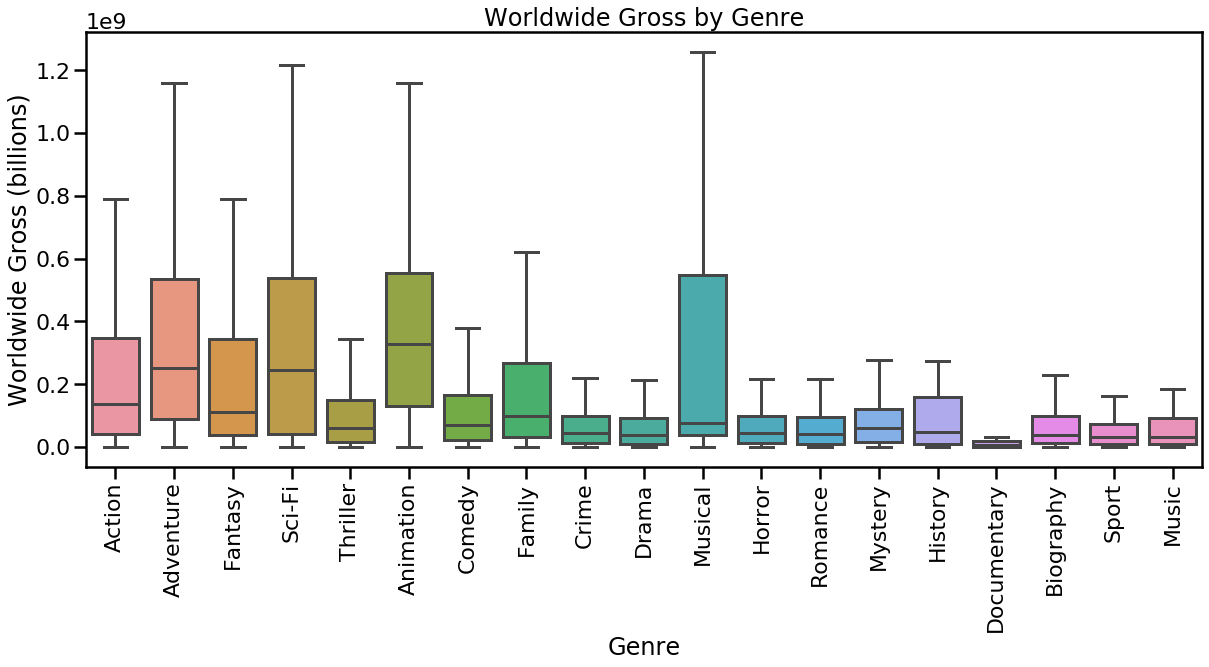

In [16]:
# visualize worldwide gross by genre, remove outliers
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.boxplot(x='Genre', y='worldwide_gross', data=genre_info, showfliers=False)
plt.ylabel('Worldwide Gross (billions)')
plt.title('Worldwide Gross by Genre');

## Q3: What does the distribution of production budgets look like across each genre?

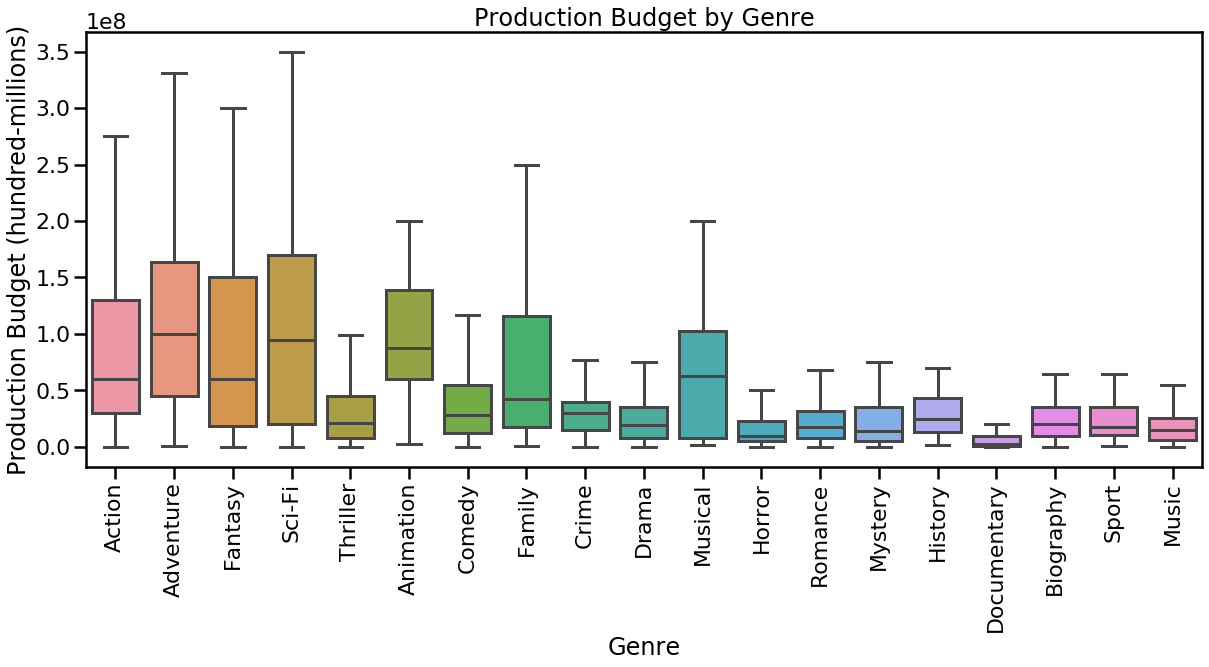

In [17]:
# visualize the production budget by genre, removing outliers
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.boxplot(x='Genre', y='production_budget', data=genre_info, showfliers=False)
plt.ylabel('Production Budget (hundred-millions)')
plt.title('Production Budget by Genre');

## Q4: What is the average ROI for each genre, given the production budget and worldwide gross?

In [18]:
# create a new column with the ROI for each movie in each genre
genre_info['ROI'] = genre_info['production_budget'] / genre_info['worldwide_gross']

# drop any infinite values, if they exist
drop_inf = genre_info.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

# create a new dataframe showing the average ROI by genre
drop_inf = pd.DataFrame(drop_inf.groupby('Genre')['ROI'].mean())
drop_inf.reset_index(inplace = True)

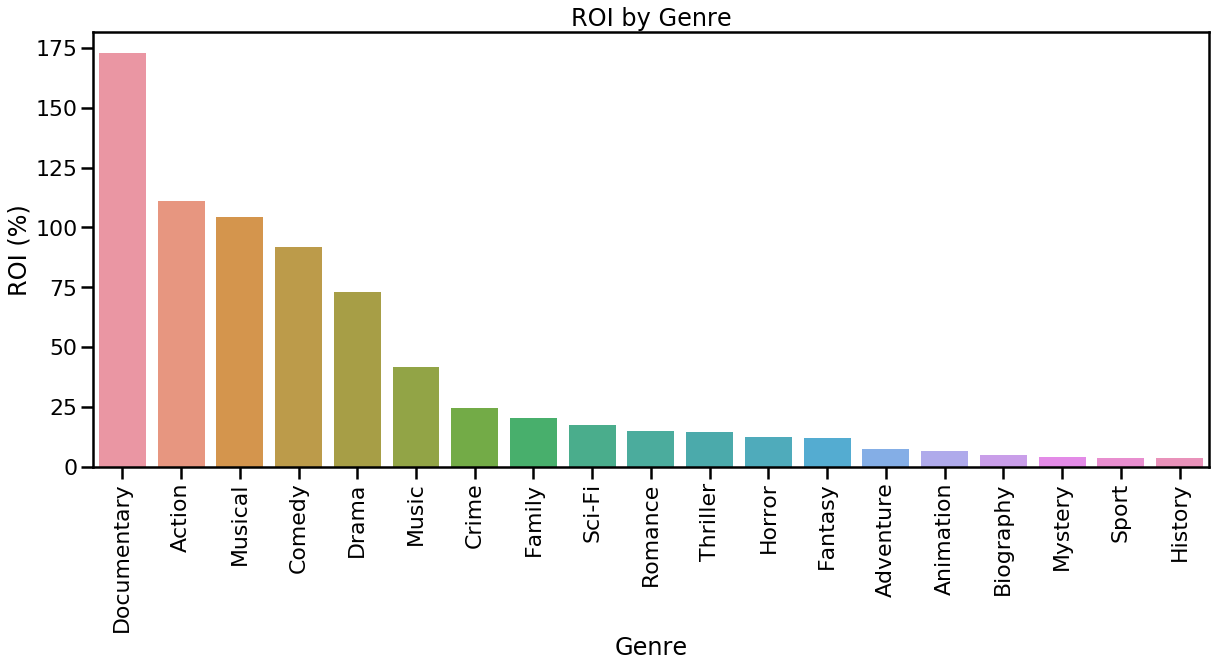

In [19]:
# visualize the ROI by genre
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.barplot(x='Genre', y='ROI', data=drop_inf, order=drop_inf.sort_values('ROI', ascending=False).Genre)
plt.title('ROI by Genre')
plt.ylabel('ROI (%)');

# Explore the ratings of each genre

## Q5: What does the distribution of ratings look like by genre?

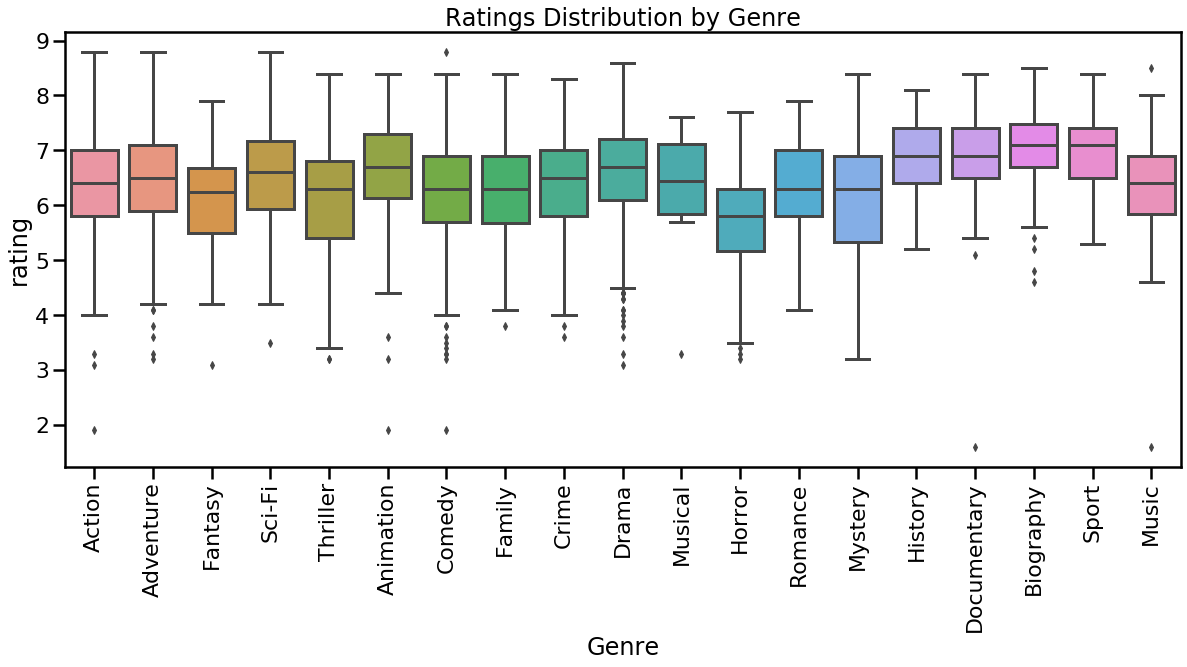

In [20]:
# create a boxplot of movie ratings
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.boxplot(x='Genre', y='rating', data=genre_info)
plt.title('Ratings Distribution by Genre');

## Q6: What is the average rating for each genre?

In [21]:
# create a new dataframe showing the average rating by genre
average_rating = pd.DataFrame(genre_info.groupby('Genre')['rating'].mean())
average_rating.reset_index(inplace=True)

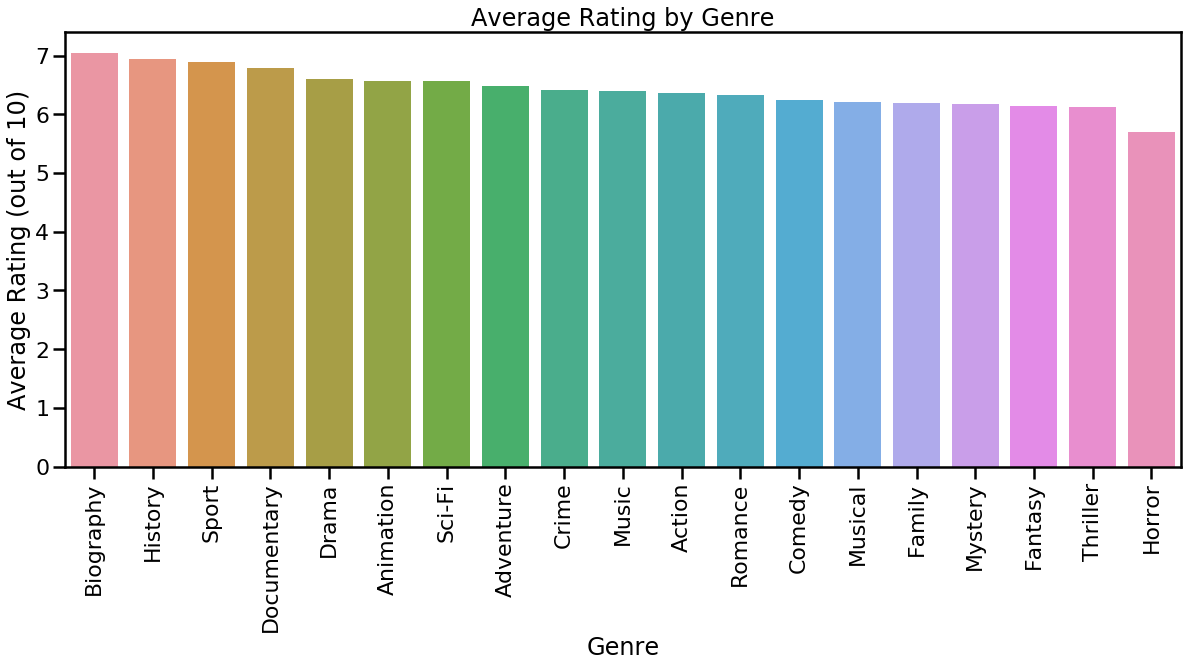

In [22]:
# visualize the results
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.barplot(x='Genre', y='rating', data=average_rating, order=average_rating.sort_values('rating', ascending=False).Genre)
plt.title('Average Rating by Genre')
plt.ylabel('Average Rating (out of 10)');

In [58]:
genre_median = genre_info.groupby('Genre')['worldwide_gross', 'production_budget'].median()
genre_median.sort_values('production_budget', ascending=False, inplace=True)
genre_median

/Users/dominickdandrea/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,worldwide_gross,production_budget
Genre,,
Adventure,250795637.5,100000000
Sci-Fi,243511801.5,95000000
Animation,327829122.5,87500000
Musical,75792303.5,62500000
Action,135965960.0,60000000
Fantasy,110635328.0,60000000
Family,97846798.5,42500000
Crime,45671512.0,30000000
Comedy,68848446.0,28000000


In [45]:
genre_median.sort_values('worldwide_gross', ascending=False)

,worldwide_gross,production_budget
Genre,,
Animation,327829122.5,87500000
Adventure,250795637.5,100000000
Sci-Fi,243511801.5,95000000
Action,135965960.0,60000000
Fantasy,110635328.0,60000000
Family,97846798.5,42500000
Musical,75792303.5,62500000
Comedy,68848446.0,28000000
Mystery,61166295.5,14000000


In [52]:
genre_ratings_avg = pd.DataFrame(genre_info.groupby('Genre')['rating'].mean())
genre_ratings_avg.sort_values('rating', ascending=False, inplace=True)
genre_ratings_avg

,rating
Genre,
Biography,7.051538
History,6.946154
Sport,6.896970
Documentary,6.790909
Drama,6.603829
Animation,6.574490
Sci-Fi,6.565873
Adventure,6.489181
Crime,6.405882


In [57]:
genre_roi = pd.DataFrame(drop_inf.groupby('Genre')['ROI'].mean())
genre_roi.sort_values('ROI', ascending=False, inplace=True)
genre_roi

,ROI
Genre,
Documentary,173.121062
Action,111.171112
Musical,104.250647
Comedy,91.995824
Drama,72.827988
Music,41.551239
Crime,24.598919
Family,20.451557
Sci-Fi,17.372825


In [59]:
genre_df

,Genre,Count
0,Documentary,51639
1,Drama,49882
2,Comedy,25311
3,Thriller,11882
4,Horror,10804
5,Action,10334
6,Romance,9371
7,Biography,8721
8,Crime,6752
9,Adventure,6464
